In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy
import os

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0).copy()
    data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"], inplace=True)
    data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1}, inplace=True)
    data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''}, inplace=True)

    # data above 30 requires a 2nd ingredient to be valid.
    data.drop(  data.index[(data["Level"] >= 30) & (data["Amnt"] == 0.0)] , inplace=True )

    # data below 30 we clear 2nd ingredient
    data.loc[data["Level"] < 30, "Amnt"] = 0.0
    data.loc[data["Level"] < 30, "Ing2P"] = 0.0
    data.loc[data["Level"] < 30, "Ingredient 2"] = ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data.loc[data["Level"] < 25, "Sub Skill 2"] = ""
    data.loc[data["Level"] < 10, "Sub Skill 1"] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    # (We now trust the bugged data is quarantined so we can use the valid data)
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data.drop( data.index[~data["Pokemon"].isin( game.pokedex.data["Pokemon"]) ], inplace=True )
    
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.0,6298.000000,6298.000000,6298.000000,6298.000000
mean,10.568752,604.277072,1.491426,604.317798,0.040726,3958.844077,3809.132584,12.221340,28.044776,37.712925,108.864560,1.017633,0.988404,0.994754,1.001207,1.005176,0.207796,32.639038,55.126548,148.948079,1.0,0.072721,2.975707,0.987685,1.027737
std,7.138779,389.355772,0.983268,389.410942,0.960091,962.872171,1024.241487,3.383991,2.609196,8.009850,16.016822,0.303905,0.059301,0.045062,0.117886,0.118129,0.044898,36.128194,27.676665,60.660176,0.0,0.512616,20.491814,0.037644,0.069859
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.880000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,354.000000,1.000000,354.267500,-0.280000,3300.000000,2953.125000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.810000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,460.000000,1.000000,459.935000,-0.010000,3900.000000,3794.350000,12.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.980000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,711.750000,2.000000,711.607500,0.270000,4500.000000,4455.000000,14.000000,31.000000,42.000000,115.000000,1.210000,1.000000,1.000000,1.000000,1.000000,0.240000,43.980000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.430000,10.460000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.950000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [7]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    6298.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [8]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)


count    6298.000000
mean        0.508754
std         1.317340
min         0.000053
25%         0.132468
50%         0.274183
75%         0.430987
max        20.198165
dtype: float64

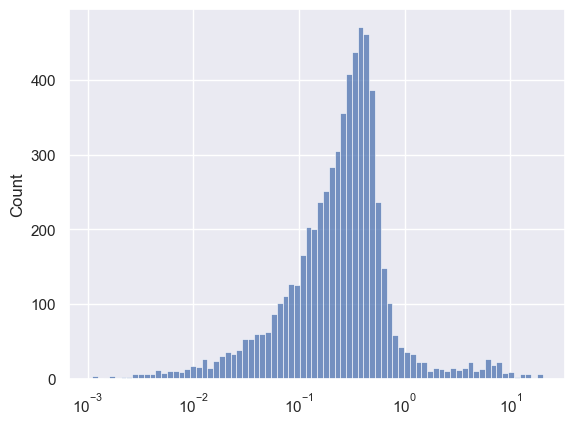

In [9]:
# what is the quality of the initial guess?

r = np.abs(residual(x0))
pd.Series(r).describe()
_ = sns.histplot(x=r[r>1e-3], log_scale=True)

In [10]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:
    opt = scipy.optimize.least_squares(residual, x0, **fit_options.least_squares_kwargs)
    
    # save results and remove some stuff we don't need to save.
    del opt.jac
    del opt.active_mask
    del opt.fun
    
    save(filename, opt)

Loaded from cache


In [11]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.566e-01  2.547e-01 ...  2.200e-01  9.939e-01]
       cost: 731.1402517870247
       grad: [ 1.288e-05  2.205e-06 ...  0.000e+00  2.374e-05]
 optimality: 0.04451485816389322
       nfev: 46
       njev: 28

count    6298.000000
mean        0.344054
std         0.747334
min         0.000068
25%         0.123172
50%         0.253244
75%         0.392165
max        15.931031
dtype: float64

<Axes: ylabel='Count'>

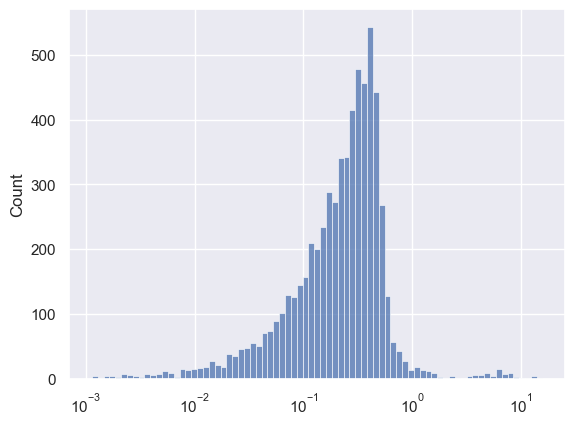

In [12]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt>1e-3], log_scale=True)

In [13]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25660485 0.2546592 0.26558725 ... 0.17965894 0.20072728 0.21576623]
Pokemons skill products,[16.70775155 16.71019417 18.47212784 ... 44.69877016 12.78777048 15.57331512]
Charge Strength S,[0.74663253 0.32238446]
Charge Strength M,[0.74550835 0.32264474]
Ingredient Magnet S,[0.74531037 0.32270798]
Cooking Power-Up S,[0.74537294 0.32271979]
Extra Helpful S,[0.74578073 0.32229191]
Charge Energy S,[0.74793818 0.32197594]
Energizing Cheer S,[0.74756082 0.32152903]
Energy for Everyone S,[0.74551483 0.3228293 ]
Dream Shard Magnet S,[0.74512412 0.32233414]


In [14]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.pokedex.data["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.660485,16.707752
Ivysaur,25.465920,16.710194
Venusaur,26.558725,18.472128
Charmander,20.068551,9.667941
Charmeleon,22.683315,14.054277
Charizard,22.380776,14.056919
Squirtle,27.047718,17.601948
Wartortle,27.069130,17.579325
Blastoise,27.450073,18.445738


In [15]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.mainskills.data.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.422743,1.421341,1.421143,1.421296,1.420857,1.424067,1.422077,1.421878,1.419726,1.421739
3,1.963976,1.962551,1.962402,1.962637,1.961191,1.965001,1.961378,1.963655,1.959713,1.963781
4,2.711103,2.709841,2.709807,2.710162,2.707008,2.711410,2.705202,2.711866,2.705082,2.712477
5,3.742449,3.741680,3.741870,3.742405,3.736450,3.741343,3.731109,3.745167,3.733948,3.746615
6,5.166134,5.166418,5.167006,5.167806,5.157376,5.162499,5.146076,5.172186,5.154141,5.175020


In [16]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1234,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1888.068969,15.931031,253.797740
2159,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1740.569124,13.430876,180.388442
2801,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1699.739140,13.260860,175.850407
2802,Victreebel,VictreebelNeutral323Energy Recovery BonusInven...,32.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1751.0,1737.946454,13.053546,170.395056
2158,Raichu,RaichuLonely264Skill Level Up MInventory Up M,26.0,4.0,Speed of Help,Energy Recovery,Skill Level Up M,Inventory Up M,1356.0,1343.278348,12.721652,161.840434
2803,Victreebel,VictreebelNeutral333Energy Recovery BonusInven...,33.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1769.0,1756.852627,12.147373,147.558675
1401,Haunter,HaunterMild302Inventory Up MSleep EXP Bonus,30.0,2.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1327.0,1316.547945,10.452055,109.245461
2205,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.942941,9.057059,82.030320
2603,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.965167,9.034833,81.628202
2727,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1752.286672,8.713328,75.922086
